# Comparaison des distances inter-distributions
Dans ce notebook on compare selon plusieurs critères les performances entre plusieurs distances (KLD, MMD-RBF, MMD_IRQ)

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from math import *
import seaborn as sns

def KLD(var, mu):
    return .5 * (var - 1 + mu**2 - np.log(var))

In [5]:
mu = np.linspace(0,10,6).reshape(1,6)
var = np.linspace(.1,15,1000).reshape(1000,1)

In [6]:
def KL_bench(var,mu):
    KL_bench = KLD(var,mu)
    plt.plot(var,KL_bench)
    
    plt.xlabel("var")
    plt.ylabel("KLD")

In [9]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def RBF_bench(var,mu,n):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    var = torch.from_numpy(var).float().squeeze(1).to(device)
    mu  = torch.from_numpy(mu).float().squeeze(0).to(device)
    
    RBF = torch.zeros([len(mu),len(var)]).to(device)
    
    for i in range(len(mu)):
        for j in range(len(var)):
            sample = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
            prior  = torch.randn(n)
            RBF[i,j] = compute_mmd(sample.unsqueeze(1),prior.unsqueeze(1))
    plt.plot(var.numpy(),RBF.numpy().T)
    plt.xlabel("var")
    plt.ylabel("MMDRBF")
    
    
    
    #########################################################################
    
    
def im_kernel_sum(z1, z2, z_var, exclude_diag=True):
    r"""Calculate sum of sample-wise measures of inverse multiquadratics kernel described in the WAE paper.
    Args:
        z1 (Tensor): batch of samples from a multivariate gaussian distribution \
            with scalar variance of z_var.
        z2 (Tensor): batch of samples from another multivariate gaussian distribution \
            with scalar variance of z_var.
        exclude_diag (bool): whether to exclude diagonal kernel measures before sum it all.
    """
    assert z1.size() == z2.size()
    assert z1.ndimension() == 2

    z_dim = z1.size(1)
    C = 2*z_dim*z_var

    z11 = z1.unsqueeze(1).repeat(1, z2.size(0), 1)
    z22 = z2.unsqueeze(0).repeat(z1.size(0), 1, 1)
    
    ########################################
    #############################################################
    '''
    print(z_dim)
    print(len(C))
    print(len(z11[:,0]))
    print(len(z11[0,:]))
    print(len(z22[:,0]))
    print(len(z22[0,:]))
    '''
    #############################################################
    ########################################

    kernel_matrix = C/(1e-9+C+(z11-z22).pow(2).sum(2))
    kernel_sum = kernel_matrix.sum()
    # numerically identical to the formulation. but..
    if exclude_diag:
        kernel_sum -= kernel_matrix.diag().sum()

    return kernel_sum

    ####################

def imq_mmd(z_tilde, z, z_var):
    r"""Calculate maximum mean discrepancy described in the WAE paper.
    Args:
        z_tilde (Tensor): samples from deterministic non-random encoder Q(Z|X).
            2D Tensor(batch_size x dimension).
        z (Tensor): samples from prior distributions. same shape with z_tilde.
        z_var (Number): scalar variance of isotropic gaussian prior P(Z).
    """
    assert z_tilde.size() == z.size()
    assert z.ndimension() == 2

    n = z.size(0)
    ########################
    #####################################################
    '''
    sample = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
    prior  = torch.randn(n)
    RBF[i,j] = compute_mmd(sample.unsqueeze(1),prior.unsqueeze(1))
    '''
    ######################################################
    #######################
    
    out = im_kernel_sum(z, z, z_var, exclude_diag=True).div(n*(n-1)) + \
          im_kernel_sum(z_tilde, z_tilde, z_var, exclude_diag=True).div(n*(n-1)) + \
          -im_kernel_sum(z, z_tilde, z_var, exclude_diag=False).div(n*n).mul(2)
    
    ########################
    #####################################################
    '''plt.plot(var.numpy(),RBF.numpy().T,out.numpy().T)
    plt.xlabel("var")
    plt.ylabel("MMDIMQ")
    plt.show()'''
    ######################################################
    #######################
    
    return out

def IMQ_bench(var,mu,n):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    IMQ = torch.zeros([len(mu[0,:]),len(var)]).to(device)
    print(len(IMQ[:,0]))
    print(len(IMQ[0,:]))
    x = torch.zeros([n,1]).to(device)
    y = torch.zeros([n,1]).to(device)
    
    var = torch.from_numpy(var).float().squeeze(1).to(device)
    mu  = torch.from_numpy(mu).float().squeeze(0).to(device)
    #print(len(x[:,0]))
    #print(len(x[0,:]))
    
    for i in range(len(mu)):
        for j in range(len(var)):
            x[:,0] = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
            #x[:,1] = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
            y[:,0] = torch.randn(n)
            #y[:,1] = torch.randn(n)
                   
            
            '''
            x[:,1] = sample[:]
            x[:,2] = sample[:]
            y[:,1] = prior[:]
            y[:,2] = prior[:]
            
            x_kernel = compute_kernel(x, x)
            y_kernel = compute_kernel(y, y)
            '''
            IMQ[i,j] = imq_mmd(x, y, var)

    plt.plot(var.numpy(),IMQ.numpy().T)
    plt.xlabel("var")
    plt.ylabel("MMDIMQ")  
    

6
1000


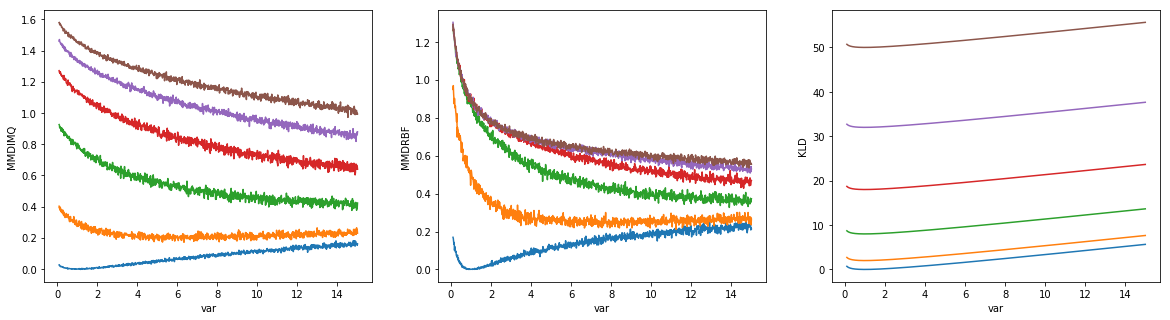

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(131)
IMQ_bench(var,mu,1000)
plt.subplot(132)  
RBF_bench(var,mu,1000)
plt.subplot(133)
KL_bench(var,mu)
plt.savefig("bench.png")

<Figure size 432x288 with 0 Axes>